<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/MLDA_ViT4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

›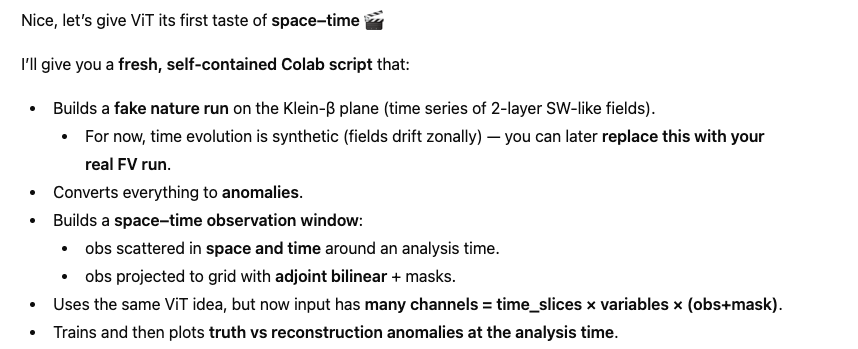

# 1. Imports and basic configuration

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# 2. IC generator and a fake time-elvolving nature run

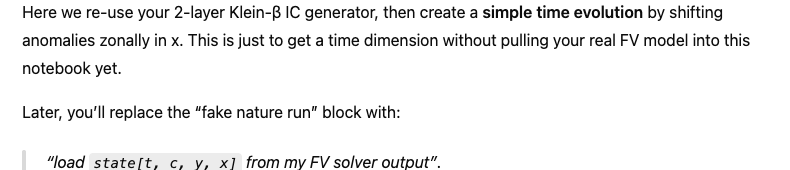

In [ ]:
# ============================================
# 2.1 Two-layer SW initial condition on Klein-β
# ============================================
def make_ic_sw2l_klein(
    Nx=128,
    Ny=64,
    Lx=2.0e7,     # domain length in x (m) ~ 20,000 km
    Ly=6.0e6,     # domain length in y (m) ~ 6,000 km
    g=9.81,
    H1=500.0,     # mean depth layer 1 (m)
    H2=500.0,     # mean depth layer  2 (m)
    f0=1.0e-4,    # reference Coriolis (s^-1)
    beta=2.0e-11, # beta parameter (1/(m s))
    A_bt=10.0,    # barotropic height amplitude (m)
    A_bc=20.0,    # baroclinic height amplitude (m)
    alpha=1.0,    # how strongly baroclinic the anomaly is
    R_frac=0.15,  # Gaussian radius as fraction of Lx
    noise_amp=0.05, # small velocity noise (m/s)
    seed=None,
):
    """
    Create a single initial condition for a 2-layer SW model
    on a Klein-beta rectangular channel.

    Returns:
      h1, h2, u1, v1, u2, v2  each shape (Ny, Nx)
    """
    rng = np.random.RandomState(seed)

    # --- Grid in physical space ---
    dx = Lx / Nx
    dy = Ly / Ny
    x = (np.arange(Nx) + 0.5) * dx
    y = (np.arange(Ny) + 0.5) * dy
    X, Y = np.meshgrid(x, y)  # (Ny, Nx)

    # Central latitude y0 (for f(y) if needed)
    y0 = 0.5 * Ly
    f = f0 + beta * (Y - y0)  # not used directly below, but kept for completeness

    # --- Choose Gaussian center & radius for baroclinic part ---
    x_c = rng.uniform(0.3 * Lx, 0.7 * Lx)
    y_c = rng.uniform(0.3 * Ly, 0.7 * Ly)
    R = R_frac * Lx

    # --- Barotropic anomaly (same sign in both layers) ---
    eta_bt = A_bt * np.sin(2.0 * np.pi * X / Lx) * np.sin(np.pi * Y / Ly)

    # --- Baroclinic anomaly (opposite sign in two layers) ---
    rr2 = (X - x_c) ** 2 + (Y - y_c) ** 2
    eta_bc = A_bc * np.exp(-rr2 / R**2) * np.cos(2.0 * np.pi * X / Lx)

    # Surface anomalies for each layer
    eta1 = eta_bt + alpha * eta_bc
    eta2 = eta_bt - alpha * eta_bc

    # Total layer depths (ensure positive)
    h1 = H1 + eta1
    h2 = H2 + eta2
    h1 = np.maximum(h1, 1.0)
    h2 = np.maximum(h2, 1.0)

    # --- Approximate geostrophic velocities (using constant f0) ---
    f_ref = f0

    def ddx(field):
        # Periodic in x
        return (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2.0 * dx)

    def ddy(field):
        # "Wall" boundaries in y (Neumann)
        f_p = np.empty_like(field)
        f_m = np.empty_like(field)
        f_p[1:-1, :] = field[2:, :]
        f_m[1:-1, :] = field[:-2, :]
        f_p[0, :] = field[1, :]
        f_m[0, :] = field[0, :]
        f_p[-1, :] = field[-1, :]
        f_m[-1, :] = field[-2, :]
        return (f_p - f_m) / (2.0 * dy)

    d_eta1_dx = ddx(eta1)
    d_eta1_dy = ddy(eta1)
    d_eta2_dx = ddx(eta2)
    d_eta2_dy = ddy(eta2)

    # Geostrophic relation: u = -g/f ∂η/∂y, v = g/f ∂η/∂x
    u1 = - (g / f_ref) * d_eta1_dy
    v1 =   (g / f_ref) * d_eta1_dx
    u2 = - (g / f_ref) * d_eta2_dy
    v2 =   (g / f_ref) * d_eta2_dx

    # Small random velocity noise to break symmetry
    u1 += noise_amp * rng.randn(*u1.shape)
    v1 += noise_amp * rng.randn(*v1.shape)
    u2 += noise_amp * rng.randn(*u2.shape)
    v2 += noise_amp * rng.randn(*v2.shape)

    return h1, h2, u1, v1, u2, v2


## 2.2 Fake time evolution (nature run)

### Here we create a "nature run" that just shifts patterns zonally to mimic time evolution

In [ ]:
# ============================================
# 2.2 Build a fake time-evolving nature run
# ============================================
def build_fake_nature_run_sw2l(
    T=40,        # number of time steps
    Nx=128,
    Ny=64,
    seed=123,
):
    """
    Build a *fake* time-resolved "nature run" for 2-layer SW
    on Klein-beta plane.

    For now we:
      - generate a single IC using make_ic_sw2l_klein
      - convert to anomalies later
      - at each time, shift the fields zonally (in x) by a few grid points
        to mimic propagation.

    Returns:
      truth: array of shape (T, 6, Ny, Nx)
             [h1, h2, u1, v1, u2, v2]
    """
    rng = np.random.RandomState(seed)
    C_state = 6
    truth = np.zeros((T, C_state, Ny, Nx), dtype=np.float32)

    # Create base IC (t=0)
    h1, h2, u1, v1, u2, v2 = make_ic_sw2l_klein(Nx=Nx, Ny=Ny, seed=seed)
    state0 = np.stack([h1, h2, u1, v1, u2, v2], axis=0)  # (6,Ny,Nx)

    # Choose a small zonal shift per time step
    # e.g. shift 1 grid point in x every 2 time steps
    shift_per_t = 1

    for t in range(T):
        # simple pattern: roll in x by shift_per_t * t
        shift = shift_per_t * t
        for c in range(C_state):
            truth[t, c] = np.roll(state0[c], shift=shift, axis=1)

        # optional: very small decay or noise
        truth[t] += 0.01 * rng.randn(Ny, Nx)[None, :, :]

    return truth

# Build fake nature run
truth_time = build_fake_nature_run_sw2l(T=40, Nx=128, Ny=64)
print("truth_time shape:", truth_time.shape)  # (T, 6, H, W)


truth_time shape: (40, 6, 64, 128)


Later: replace this block with loading your FV output, e.g.

data = np.load("truth_sw2l_klein_timeseries.npz"); truth_time = data("state")

# 3. Convert to anomalies and build space-time scattered obs dataset

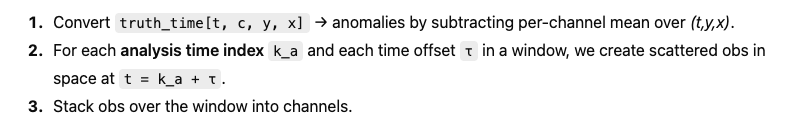

# 3.1 Anomalies

In [4]:
# ============================================
# 3.1 Convert time series to anomalies
# ============================================
T, C_state, H, W = truth_time.shape

# Channel-wise mean over (t,y,x)
channel_means = truth_time.mean(axis=(0, 2, 3), keepdims=True)  # (1, C, 1, 1)
print("Channel means (original):", channel_means.reshape(-1))

truth_anom = truth_time - channel_means
print("Anomalies: min, max, std per channel:")
for c, name in enumerate(["h1", "h2", "u1", "v1", "u2", "v2"]):
    fld = truth_anom[:, c].ravel()
    print(f"{name}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")


Channel means (original): [ 4.9723956e+02  5.0276044e+02 -1.4963428e-02  1.0019508e-03
  1.5036379e-02  4.0951039e-04]
Anomalies: min, max, std per channel:
h1: min= -19.485, max=  12.781, std=   7.551
h2: min= -13.212, max=  13.150, std=   6.148
u1: min=  -0.818, max=   0.903, std=   0.319
v1: min=  -1.036, max=   0.659, std=   0.296
u2: min=  -0.655, max=   0.640, std=   0.275
v2: min=  -0.978, max=   0.508, std=   0.265


## 3.2 Bilinear sampling and adjoint scatter (same as before)

In [5]:
# ============================================
# 3.2 Bilinear sampling & adjoint scatter
# ============================================
def sample_field_bilinear(field_2d, x, y):
    """
    Bilinear sampling from a 2D field on an A-grid.
    field_2d: (H, W)
    x, y: 1D arrays of fractional indices in [0, W), [0, H).
           (index-space, not meters)
    Periodic in x, clamped in y.
    """
    H, W = field_2d.shape
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    v00 = field_2d[y0, x0]
    v10 = field_2d[y0, x1]
    v01 = field_2d[y1, x0]
    v11 = field_2d[y1, x1]

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    vals = w00 * v00 + w10 * v10 + w01 * v01 + w11 * v11
    return vals


def scatter_to_grid_adj(x, y, v, H, W, eps=1e-6):
    """
    Adjoint of bilinear interpolation (points -> grid).

    Each observation at fractional index (x,y) contributes
    to 4 surrounding grid points with bilinear weights,
    accumulating a weighted average.

    Returns:
      grid: (H,W) interpolated values
      mask: (H,W) 1 where any obs contributed, 0 otherwise
    """
    grid_sum = np.zeros((H, W), dtype=np.float32)
    grid_wgt = np.zeros((H, W), dtype=np.float32)

    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    for k in range(len(v)):
        vv = v[k]
        i0, j0 = x0[k], y0[k]
        i1, j1 = x1[k], y1[k]

        grid_sum[j0, i0] += w00[k] * vv
        grid_wgt[j0, i0] += w00[k]
        grid_sum[j0, i1] += w10[k] * vv
        grid_wgt[j0, i1] += w10[k]
        grid_sum[j1, i0] += w01[k] * vv
        grid_wgt[j1, i0] += w01[k]
        grid_sum[j1, i1] += w11[k] * vv
        grid_wgt[j1, i1] += w11[k]

    grid = grid_sum / np.maximum(grid_wgt, eps)
    mask = (grid_wgt > 0.0).astype(np.float32)
    return grid, mask


## 3.3 Build space-time obs window dataset

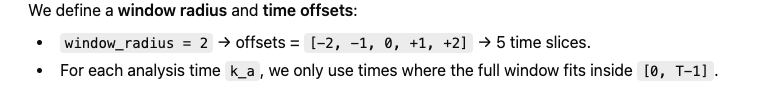

In [6]:
# ============================================
# 3.3 Build space–time obs dataset
# ============================================
def make_da_dataset_spacetime_scattered_noisy(
    truth_anom,
    window_radius=2,
    n_obs_points=2000,
    noise_frac=0.1,
    seed=123,
):
    """
    Build a DA dataset with *space-time* scattered observations.

    truth_anom: (T, C, H, W) anomalies of the nature run.
    window_radius: number of time steps on each side of analysis time.
                   e.g. 2 -> offsets = [-2,-1,0,1,2]
    n_obs_points: number of scattered obs *per time slice* (same points for all channels)
    noise_frac:   obs noise std = noise_frac * channel_std[c]
    seed: RNG seed

    For each analysis time index k_a (where the window fits):
      - time offsets: tau in [-window_radius,...,+window_radius]
      - for each offset:
          * take truth_anom[t = k_a + tau]
          * sample scattered obs in space, add noise, scatter-to-grid
      - Stack obs over time and channels:
          obs_stack shape:  (N_t * C, H, W)
          mask_stack shape: (N_t * C, H, W)
        where N_t = 2*window_radius + 1
      - Input X[i] = [obs_stack, mask_stack]  shape (2 * N_t * C, H, W)
      - Target Y[i] = truth_anom[k_a]         shape (C, H, W)

    Returns:
      X: (N_samples, C_in, H, W),  C_in = 2 * N_t * C
      Y: (N_samples, C,     H, W)
    """
    rng = np.random.RandomState(seed)
    T, C, H, W = truth_anom.shape

    # Time offsets in the window, e.g. [-2,-1,0,1,2]
    time_offsets = np.arange(-window_radius, window_radius + 1)
    N_t = len(time_offsets)

    # Valid analysis times (k_a) such that the full window fits in [0, T-1]
    valid_ka = np.arange(window_radius, T - window_radius)
    N_samples = len(valid_ka)

    # Per-channel std over entire run (for noise scaling)
    channel_std = truth_anom.reshape(T, C, -1).std(axis=(0, 2))
    print("Channel std (anomalies):", channel_std)

    C_in = 2 * N_t * C  # obs + mask, for each time slice and channel
    X = np.zeros((N_samples, C_in, H, W), dtype=np.float32)
    Y = np.zeros((N_samples, C,   H, W), dtype=np.float32)

    for i, k_a in enumerate(valid_ka):
        # Obs and mask over time window
        obs_grid = np.zeros((N_t, C, H, W), dtype=np.float32)
        mask_grid = np.zeros((N_t, C, H, W), dtype=np.float32)

        for it, tau in enumerate(time_offsets):
            t_idx = k_a + tau
            field_t = truth_anom[t_idx]  # (C,H,W) at that time

            # Random obs locations in index space for this time slice
            x_obs = rng.uniform(0.0, W, size=n_obs_points)
            y_obs = rng.uniform(0.0, H, size=n_obs_points)

            for c in range(C):
                field_c = field_t[c]
                vals_clean = sample_field_bilinear(field_c, x_obs, y_obs)

                sigma_c = noise_frac * channel_std[c]
                if sigma_c == 0.0:
                    noise = 0.0
                else:
                    noise = sigma_c * rng.randn(n_obs_points)

                vals = vals_clean + noise

                g_c, m_c = scatter_to_grid_adj(x_obs, y_obs, vals, H, W)
                obs_grid[it, c] = g_c
                mask_grid[it, c] = m_c

        # Stack time and channels along channel axis
        obs_stack  = obs_grid.reshape(N_t * C, H, W)
        mask_stack = mask_grid.reshape(N_t * C, H, W)

        X[i] = np.concatenate([obs_stack, mask_stack], axis=0)
        Y[i] = truth_anom[k_a]

    return X, Y


# Build DA dataset with space-time obs
window_radius = 2      # time offsets: -2,-1,0,1,2
n_obs_points = 2000    # per time slice
noise_frac   = 0.1     # 10% of channel std as obs noise

X, Y = make_da_dataset_spacetime_scattered_noisy(
    truth_anom,
    window_radius=window_radius,
    n_obs_points=n_obs_points,
    noise_frac=noise_frac,
    seed=123,
)
print("X shape:", X.shape)  # (N_samples, C_in, H, W)
print("Y shape:", Y.shape)  # (N_samples, C_state, H, W)


Channel std (anomalies): [7.5510225  6.148047   0.31894827 0.29639015 0.2749371  0.2653804 ]
X shape: (36, 60, 64, 128)
Y shape: (36, 6, 64, 128)


### Optional quick look at obs

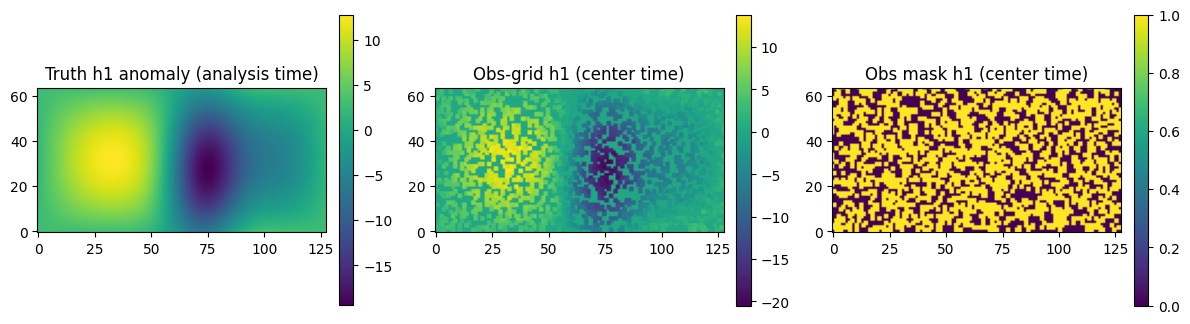

In [7]:
# Quick sanity plot for h1: obs at central slice in window
i_sample = 0
C = C_state
N_t = 2 * window_radius + 1
C_in = X.shape[1]

# Reshape obs/mask back to (N_t, C, H, W)
obs_all  = X[i_sample, :N_t*C].reshape(N_t, C, H, W)
mask_all = X[i_sample, N_t*C:].reshape(N_t, C, H, W)

# Choose central time slice in window and variable h1 (c=0)
it_center = window_radius
h1_truth = Y[i_sample, 0]
h1_obs_center  = obs_all[it_center, 0]
h1_mask_center = mask_all[it_center, 0]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(h1_truth - h1_truth.mean(), origin="lower")
axs[0].set_title("Truth h1 anomaly (analysis time)")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(h1_obs_center, origin="lower")
axs[1].set_title("Obs-grid h1 (center time)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(h1_mask_center, origin="lower")
axs[2].set_title("Obs mask h1 (center time)")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# 4. ViT model: same idea, just more input channels

The only real ifference vs the static ViT is that in_chans = X.shape[1] now includes obs from multiple times.

In [8]:
# ============================================
# 4. ViT-based DA model (space-time window)
# ============================================
class PatchEmbed2D(nn.Module):
    def __init__(self, in_chans, embed_dim, patch_size, img_size):
        super().__init__()
        self.patch_size = patch_size
        H, W = img_size
        assert H % patch_size == 0 and W % patch_size == 0, \
            "img_size must be divisible by patch_size"
        self.Hp = H // patch_size
        self.Wp = W // patch_size
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        x = self.proj(x)  # (B, E, Hp, Wp)
        B, E, Hp, Wp = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x, (Hp, Wp)


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio, drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class ViT_DA_SpaceTime(nn.Module):
    """
    ViT-based DA with a *space-time* obs window:
      input:  (B, C_in, H, W)  [obs over times, masks over times]
      output: (B, C_state, H, W)  anomalies at analysis time
    """
    def __init__(
        self,
        in_chans,
        out_chans,
        img_size,
        patch_size=8,
        embed_dim=128,
        depth=4,
        num_heads=4,
        mlp_ratio=4.0,
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size

        self.patch_embed = PatchEmbed2D(
            in_chans=in_chans,
            embed_dim=embed_dim,
            patch_size=patch_size,
            img_size=img_size,
        )
        Hp, Wp = self.patch_embed.Hp, self.patch_embed.Wp
        self.num_patches = Hp * Wp

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                drop=0.0,
            ) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        self.head_conv = nn.Sequential(
            nn.Conv2d(embed_dim, 64, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(64, out_chans, kernel_size=1),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        tokens, (Hp, Wp) = self.patch_embed(x)
        tokens = tokens + self.pos_embed
        for blk in self.blocks:
            tokens = blk(tokens)
        tokens = self.norm(tokens)
        x_p = tokens.transpose(1, 2).reshape(B, -1, Hp, Wp)
        x_p = F.interpolate(
            x_p, scale_factor=self.patch_size,
            mode="bilinear", align_corners=False
        )
        out = self.head_conv(x_p)
        return out


# 5. Data loaders and training

In [9]:
# ============================================
# 5. Prepare datasets & loaders
# ============================================
X_torch = torch.from_numpy(X)  # (N_samples, C_in, H, W)
Y_torch = torch.from_numpy(Y)  # (N_samples, C_state, H, W)

N_samples, C_in, H, W = X_torch.shape
C_state = Y_torch.shape[1]
print("N_samples, C_in, C_state, H, W =", N_samples, C_in, C_state, H, W)

idx = np.arange(N_samples)
np.random.shuffle(idx)
n_train = int(0.8 * N_samples)
idx_train = idx[:n_train]
idx_val   = idx[n_train:]

train_ds = TensorDataset(X_torch[idx_train], Y_torch[idx_train])
val_ds   = TensorDataset(X_torch[idx_val],   Y_torch[idx_val])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)


# ============================================
# 5.2 Model, loss, optimizer
# ============================================
model_vit = ViT_DA_SpaceTime(
    in_chans=C_in,
    out_chans=C_state,
    img_size=(H, W),
    patch_size=8,
    embed_dim=128,
    depth=4,
    num_heads=4,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_vit.parameters(), lr=1e-4)

def eval_rmse(model, loader, device):
    model.eval()
    se_sum = 0.0
    n_vals = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            se_sum += ((out - yb) ** 2).sum().item()
            n_vals += yb.numel()
    mse = se_sum / n_vals
    return np.sqrt(mse)


# ============================================
# 5.3 Training loop
# ============================================
n_epochs = 20
train_losses = []
val_rmses = []

for epoch in range(1, n_epochs + 1):
    model_vit.train()
    total_loss = 0.0
    n_samp = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model_vit(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n_samp += xb.size(0)

    train_loss = total_loss / n_samp
    val_rmse = eval_rmse(model_vit, val_loader, device)
    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.3e} | val_RMSE={val_rmse:.3e}")


N_samples, C_in, C_state, H, W = 36 60 6 64 128
Epoch 001 | train_loss=1.348e+01 | val_RMSE=3.290e+00
Epoch 002 | train_loss=9.617e+00 | val_RMSE=2.871e+00
Epoch 003 | train_loss=7.404e+00 | val_RMSE=2.530e+00
Epoch 004 | train_loss=5.783e+00 | val_RMSE=2.245e+00
Epoch 005 | train_loss=4.566e+00 | val_RMSE=1.998e+00
Epoch 006 | train_loss=3.621e+00 | val_RMSE=1.781e+00
Epoch 007 | train_loss=2.881e+00 | val_RMSE=1.591e+00
Epoch 008 | train_loss=2.303e+00 | val_RMSE=1.425e+00
Epoch 009 | train_loss=1.850e+00 | val_RMSE=1.280e+00
Epoch 010 | train_loss=1.492e+00 | val_RMSE=1.151e+00
Epoch 011 | train_loss=1.207e+00 | val_RMSE=1.038e+00
Epoch 012 | train_loss=9.803e-01 | val_RMSE=9.374e-01
Epoch 013 | train_loss=7.997e-01 | val_RMSE=8.491e-01
Epoch 014 | train_loss=6.557e-01 | val_RMSE=7.714e-01
Epoch 015 | train_loss=5.410e-01 | val_RMSE=7.034e-01
Epoch 016 | train_loss=4.497e-01 | val_RMSE=6.441e-01
Epoch 017 | train_loss=3.769e-01 | val_RMSE=5.925e-01
Epoch 018 | train_loss=3.192e-01 |

### Optionally plot loss/RMSE curve

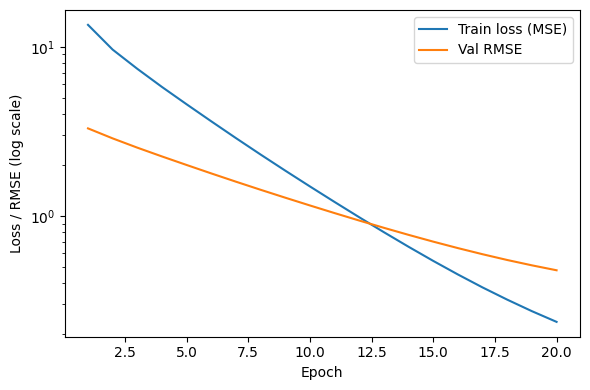

In [10]:
epochs = np.arange(1, n_epochs + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train loss (MSE)")
plt.plot(epochs, val_rmses, label="Val RMSE")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE (log scale)")
plt.legend()
plt.tight_layout()
plt.show()

# 6. Plot anomalies: truth vs reconstruciton at analysis time

In [11]:
# ============================================
# 6. Helper: anomaly plots for all vars
# ============================================
def plot_anomalies_all_vars(data, idx=0, var_names=None, title_prefix=""):
    """
    Plot anomalies (field - spatial mean) for ALL variables
    of a single sample.

    data: np.ndarray of shape (B, C, H, W)
    idx: which sample in batch
    var_names: list of variable names of length C
    """
    sample = data[idx]  # (C, H, W)
    C, H, W = sample.shape

    if var_names is None:
        var_names = [f"var{c}" for c in range(C)]
    assert len(var_names) == C

    print(f"\n[{title_prefix}] sample idx={idx}, data.shape={data.shape}")
    fig, axs = plt.subplots(1, C, figsize=(3 * C, 3))
    if C == 1:
        axs = [axs]

    for c in range(C):
        fld = sample[c]
        print(f"{title_prefix} {var_names[c]}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")
        anom = fld - fld.mean()
        print(f"{title_prefix} anom {var_names[c]}: min={anom.min():8.3f}, max={anom.max():8.3f}, std={anom.std():8.3f}")

        vmax = np.max(np.abs(anom))
        if vmax == 0:
            vmax = 1e-6
        vmin, vmax = -vmax, vmax

        im = axs[c].imshow(anom, origin="lower", vmin=vmin, vmax=vmax)
        axs[c].set_title(f"{var_names[c]} anomaly ({title_prefix})")
        axs[c].set_xticks([]); axs[c].set_yticks([])
        plt.colorbar(im, ax=axs[c], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


### Use it on a validation bathc


[Truth] sample idx=0, data.shape=(4, 6, 64, 128)
Truth h1: min= -19.469, max=  12.765, std=   7.551
Truth anom h1: min= -19.470, max=  12.765, std=   7.551
Truth h2: min= -13.187, max=  13.137, std=   6.148
Truth anom h2: min= -13.187, max=  13.137, std=   6.148
Truth u1: min=  -0.803, max=   0.881, std=   0.319
Truth anom u1: min=  -0.803, max=   0.881, std=   0.319
Truth v1: min=  -1.021, max=   0.630, std=   0.296
Truth anom v1: min=  -1.021, max=   0.630, std=   0.296
Truth u2: min=  -0.640, max=   0.619, std=   0.275
Truth anom u2: min=  -0.640, max=   0.619, std=   0.275
Truth v2: min=  -0.973, max=   0.476, std=   0.265
Truth anom v2: min=  -0.973, max=   0.476, std=   0.265


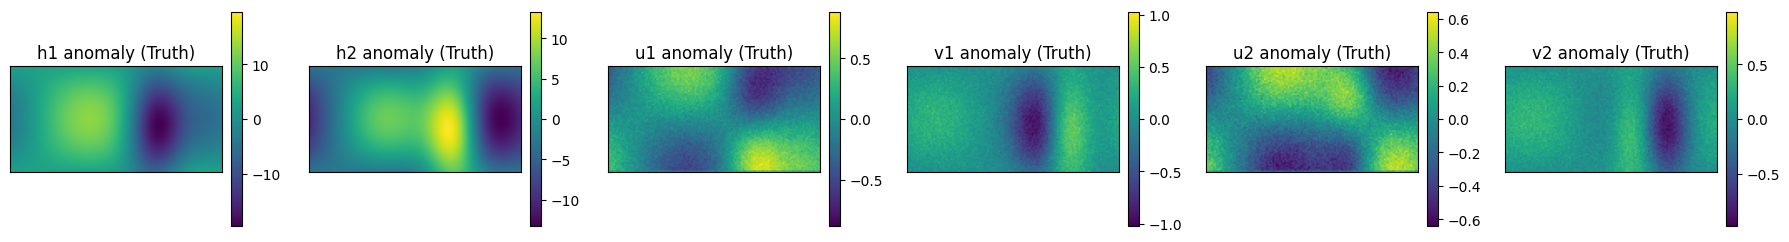


[Recon] sample idx=0, data.shape=(4, 6, 64, 128)
Recon h1: min= -15.193, max=  11.263, std=   7.233
Recon anom h1: min= -15.303, max=  11.152, std=   7.233
Recon h2: min= -12.047, max=  10.647, std=   5.896
Recon anom h2: min= -12.001, max=  10.693, std=   5.896
Recon u1: min=  -0.510, max=   0.472, std=   0.223
Recon anom u1: min=  -0.532, max=   0.450, std=   0.223
Recon v1: min=  -0.784, max=   0.636, std=   0.237
Recon anom v1: min=  -0.785, max=   0.634, std=   0.237
Recon u2: min=  -0.636, max=   0.438, std=   0.205
Recon anom u2: min=  -0.613, max=   0.462, std=   0.205
Recon v2: min=  -0.824, max=   0.432, std=   0.206
Recon anom v2: min=  -0.830, max=   0.426, std=   0.206


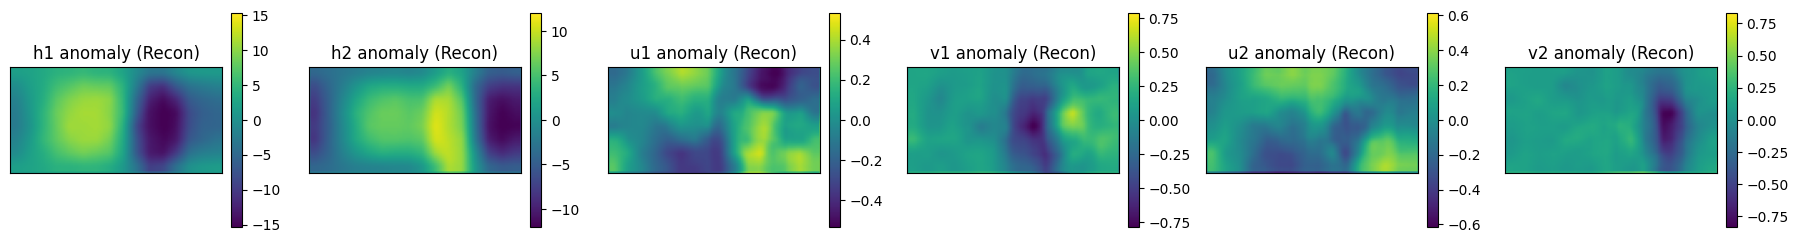


Sample RMSE (all vars, all points): 0.46897405


In [12]:
var_names = ["h1", "h2", "u1", "v1", "u2", "v2"]

model_vit.eval()
with torch.no_grad():
    xb_batch, yb_batch = next(iter(val_loader))
    xb_batch = xb_batch.to(device)
    yb_batch = yb_batch.to(device)
    y_pred_batch = model_vit(xb_batch)

y_true = yb_batch.cpu().numpy()
y_pred = y_pred_batch.cpu().numpy()

idx_example = 0

# Truth anomalies at analysis time
plot_anomalies_all_vars(
    data=y_true,
    idx=idx_example,
    var_names=var_names,
    title_prefix="Truth",
)

# Reconstruction anomalies at analysis time
plot_anomalies_all_vars(
    data=y_pred,
    idx=idx_example,
    var_names=var_names,
    title_prefix="Recon",
)

sample_rmse = np.sqrt(((y_true[idx_example] - y_pred[idx_example])**2).mean())
print("\nSample RMSE (all vars, all points):", sample_rmse)
